<a href="https://colab.research.google.com/github/Martinmbiro/Imbalanced-Datasets-and-Evaluating-Classification-Models/blob/main/03%20Resolving%20the%20Bias%20-%20possibly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolving the Bias?**

> ❗ **Recall**  
> This is an imblanced dataset as label classes are not not equally represented. Consequently, the model is biased towards the majority classes.

> Among other approaches, imbalanced datasets can be addressed in the following ways:
> + **Improving data selection**
> + Using weighted classes
> + Resampling the dataset (data augmentation)
> + Stratified sampling
> + _Tuning decision threshold for `ROC` curve_

> For this notebook, I'll be implementing _data augmentation_ by applying _resampling techniques_

## Loading the data
> Let's load our data and explore the label distribution once more

In [ ]:
import pandas as pd
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects.csv

dataset = pd.read_csv('snow_objects.csv', delimiter='\t')

In [ ]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   size       2200 non-null   float64
 1   roughness  2200 non-null   float64
 2   color      2200 non-null   object 
 3   motion     2200 non-null   float64
 4   label      2200 non-null   object 
dtypes: float64(3), object(2)
memory usage: 86.1+ KB


In [ ]:
# the color column is a categorical, hence:
dataset['color'] = dataset['color'].astype('category')

In [ ]:
# divide dataset into features and target

# features
X = dataset[['size', 'roughness', 'color', 'motion']].copy()

# target
y = dataset['label']

# the indices of the numeric and categorical features in the dataframe:
numerical_features = [0, 1, 3]
categorical_features = [2]

In [ ]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Exploring `label` distribution
> Since the `label` column contains categorical data, the `value_counts` for each label class will be used to visualize distribution in a [`bar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) graph

In [ ]:
# value_counts for each label class
dataset['label'].value_counts().sort_values(ascending=True)

label
animal    200
hiker     400
tree      800
rock      800
Name: count, dtype: int64

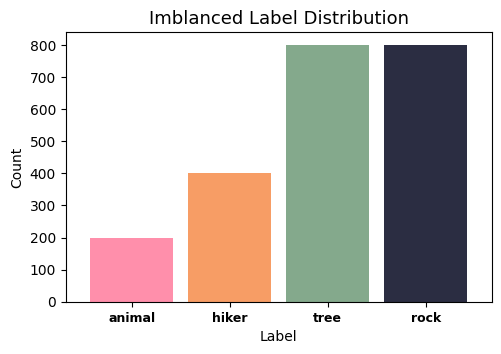

In [ ]:
# plotting the distribution
import matplotlib.pyplot as plt
# specify stylesheet
plt.style.use('fast')

# specify figure and Axes
fig, ax = plt.subplots(figsize=(5.5, 3.5))

# make the plot
dataset['label'].value_counts().sort_values(ascending=True).plot.bar(
    width = 0.85,
    color=['#FF8FAB', '#F79D65', '#84A98C', '#2B2D42'],
    ax = ax
)

# modify appearance
ax.set_title('Imblanced Label Distribution', fontsize=13)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('Label', fontsize=10)
ax.set_xticklabels(['animal', 'hiker', 'tree', 'rock'],
                   rotation=0, weight='black', fontsize=9)

plt.show()

# **Data Augmentation**
> _Data augmentation_ is the technique of artificially increasing the training set by creating modified copies of a dataset using _existing data._ To achieve this, I'll be using the [`imblearn`](https://imbalanced-learn.org/stable/index.html) library

> [`imblearn`](https://imbalanced-learn.org/stable/index.html) is an open source library that provides tools to deal with imbalanced classes

> In the end, data augmentation should improve the model's generalization ability, making it more robust to different variations and helping to prevent overfitting

## Resampling methods
> Some of the resampling approaches provided by [`imblearn`](https://imbalanced-learn.org/stable/index.html) for data augmentation include:
+ [`Undersampling the majority class`](https://imbalanced-learn.org/stable/references/under_sampling.html)
+ [`Oversampling the minority class`](https://imbalanced-learn.org/stable/references/over_sampling.html)
+ [`Hybrid methods (oversumpling + undersampling)`](https://imbalanced-learn.org/stable/references/combine.html)
+ [`Ensemble methods`](https://imbalanced-learn.org/stable/references/ensemble.html)

> In this notebook, my focus will be _oversampling, undersampling_ & _hybrid methods_. Let's dive in!

In [ ]:
# import necessary libraries
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN

### Encode the categorical feature `color`

In [ ]:
# Ordinal Encoder object
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=76)

# encode the color column (since it's categorical/nominal)
X_train[['color']] = encoder.fit_transform(X_train[['color']])

# a little peek into the now encoded dataframe
X_train.head(3)

,size,roughness,color,motion
1102,2.529090,0.812577,2.0,0.026457
1159,4.308704,1.536331,0.0,0.006440
141,60.049241,0.954721,7.0,0.000000


### [`imblearn.over_sampling.SMOTENC`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#smotenc)
+ Synthetic Minority Over-sampling Technique ([`SMOTE`](https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms)) for Categorical and Numeric data

> **Constructor:**  
```
SMOTENC(categorical_features, *, categorical_encoder=None, sampling_strategy='auto',
random_state=None, k_neighbors=5, n_jobs=None)
```

In [ ]:
# SMOTENC
# since our dataset contains a nominal (categorical) column: color

smotenc = SMOTENC(categorical_features=categorical_features,
                  sampling_strategy = 'auto',
                  random_state=42)

# resample
# Xr, yr smotenc.fit_resample(X_train, y_train)

### [`imblearn.over_sampling.ADASYN`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)
+ Oversample using Adaptive Synthetic (ADASYN) algorithm  
+ Similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled

> **Constructor:**  
```
ADASYN(*, sampling_strategy='auto', random_state=None, n_neighbors=5, n_jobs=None)
```

In [ ]:
# oversampling with ADASYN
adasyn = ADASYN(sampling_strategy = 'auto',
                random_state = 42)

#### [`imblearn.under_sampling.EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)
+ Undersample based on the edited nearest neighbour method  
+ This method cleans the dataset by removing samples close to the decision boundary

> **Constructor:**  
```
EditedNearestNeighbours(*, sampling_strategy='auto', n_neighbors=3, kind_sel='all', n_jobs=None)
```

> To apply a list of resampling techniques, I'll use `imblearn` [`Pipeline`](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline)
+ Pipeline of transforms and resamples with a possible final estimator  
+ Intermediate steps of the pipeline must be transformers or resamplers, that is, they must implement `fit`, `transform` and `sample` methods

In [ ]:
# ADASYN + ENN pipeline

adasynenn = ImbPipeline(steps=[
    # (name, sampler/transformer)
    ('adsyn', ADASYN(sampling_strategy = dict(animal=400), random_state=42)),
    ('enn', EditedNearestNeighbours(sampling_strategy=['animal']))
])

# resample
#Xr, yr = adasynenn.fit_resample(X_train, y_train)

### [`imblearn.over_sampling.BorderlineSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#r63962efaf197-2)
+ A variant of the original SMOTE algorithm  
+ Borderline samples will be detected and used to generate new synthetic samples

> **Constructor:**  
```
imblearn.over_sampling.BorderlineSMOTE(*, sampling_strategy='auto', random_state=None,
k_neighbors=5, n_jobs=None, m_neighbors=10, kind='borderline-1')
```

In [ ]:
# BorderlineSmote + ENN pipeline

blenn = ImbPipeline(steps=[
    # (name, sampler/transformer)
    ('blsmote', BorderlineSMOTE(sampling_strategy = dict(animal=400),
                                random_state=42)),
    ('enn', EditedNearestNeighbours(sampling_strategy=['animal']))
])

# resample
#Xr, yr = blenn.fit_resample(X_train, y_train)

### [`imblearn.combine.SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN)
+ Combines oversampling using Synthetic Minority Over-sampling Technique ([`SMOTE`](https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms)) with undersampling using [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html#imblearn.under_sampling.EditedNearestNeighbours)  
+ Effectively reduces noise by removing misclassified samples, leading to a cleaner dataset

> **Constructor:**  
```
SMOTEENN(*, sampling_strategy='auto', random_state=None, smote=None, enn=None, n_jobs=None)
```

> Note that the `smote` parameter can accept `SMOTE` variants such as those listed [`here`](https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms)

In [ ]:
# creating a SMOTEENN object

smoteenn = SMOTEENN(smote= smotenc,
                    enn = EditedNearestNeighbours(
                        sampling_strategy=['rock', 'tree']),
                    random_state=42,
                    n_jobs=-1)

# resample
#Xr, yr = smoteenn.fit_resample(X_train, y_train)

## Resampling the training set
> 📝 **Note**  
+ Oversampling / undersampling is done on training data; `X_train` & `y_train` **after** splitting has been done
+ Sampling before splitting would not reflect real conditions where the model would be operating, since the test set would have synthetic data  
+ Sampling classes have a method [`fit_resample(X, y)`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN.fit_resample) that resamples the dataset and returns `X_resampled` & `y_resampled`
+ For this exercise, I run all the sampling methods listed above, but found that `SMOTENC` produced the highest most consistent results on the confusion matrix (which is why it's the only one I've used to resample in this notebook)

In [ ]:
# resample using SMOTENC
X_res, y_res = smotenc.fit_resample(X_train, y_train)

# decode the color column back to its original form
X_res[['color']] = encoder.inverse_transform(X_res[['color']])
y_res.value_counts()

label
rock      578
tree      578
hiker     578
animal    578
Name: count, dtype: int64

In [ ]:
# a peek into the data
X_res.sample(3)

,size,roughness,color,motion
822,1.234860,1.512887,brown,0.316775
355,3.097799,1.104496,green,0.013944
1495,1.675287,0.000000,grey,3.849493


In [ ]:
# size of training set vs resampled set:
print(f'y_train size: {y_train.size}')
print(f'y_res set size: {y_res.size}')

y_train size: 1540
y_res set size: 2312


In [ ]:
# class distribution in resampled data
y_res.value_counts().sort_values(ascending=True)

label
rock      578
tree      578
hiker     578
animal    578
Name: count, dtype: int64

In [ ]:
# class distribution in original training data
y_train.value_counts().sort_values(ascending=True)

label
animal    136
hiker     277
tree      549
rock      578
Name: count, dtype: int64

### Visualize the difference

#### `y_train` size vs `y_res` size
> How does the size of the initial training set compare to the size of the resampled set?

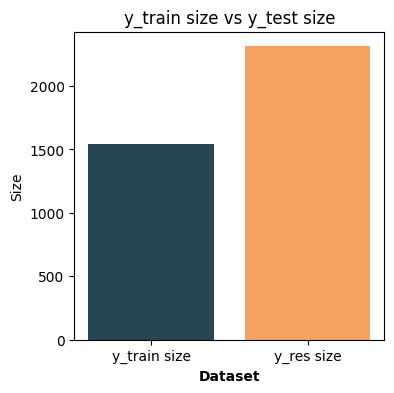

In [ ]:
# import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fast')

# specify figure and Axes
fig, ax = plt.subplots(figsize=(4, 4))

# bar graph
ax.bar(height = y_train.size, x='y_train size', color = '#264653')
ax.bar(height = y_res.size, x='y_res size', color = '#F4A261' )

# modify appearance
ax.set_ylabel('Size')
ax.set_xlabel('Dataset', weight='black')
ax.set_yticks(range(0, 2500, 500))
ax.set_title('y_train size vs y_test size')

plt.show()

#### `y_train` class distribution vs `y_res` class distribution
> How does the label distribution in the initial training set compare to the label distribution in the resampled set?

In [ ]:
# make a dataframe out of the y_train, y_res class count series
df_compare = pd.DataFrame(
    data = [y_train.value_counts().sort_index(ascending=True).values,
                     y_res.value_counts().sort_index(ascending=True).values],
    columns=['animal', 'hiker', 'rock', 'tree'],
    index=['y_train', 'y_res'])

# display the dataframe
df_compare

,animal,hiker,rock,tree
y_train,136,277,578,549
y_res,578,578,578,578


In [ ]:
# transpose the dataframe such that indices are columns and vice versa
df_compare.T

,y_train,y_res
animal,136,578
hiker,277,578
rock,578,578
tree,549,578


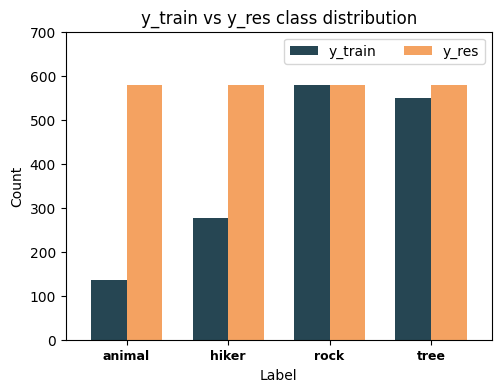

In [ ]:
# import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fast')

# specify figure and Axes
fig, ax = plt.subplots(figsize=(5.5, 4))

# bar graph
df_compare.T.plot.bar(y=['y_train', 'y_res'],
                      width = 0.7,
                      color = ['#264653', '#F4A261'],
                      ax = ax)

# modify appearance
ax.set_ylabel('Count')
ax.set_xlabel('Label')
ax.set_title('y_train vs y_res class distribution')
ax.set_xticklabels(df_compare.T.index,
                   rotation=0, weight='black', fontsize=9)
ax.set_ylim(0, 700)

plt.legend(ncols=2)
plt.show()

# **Modelling**


## Preprocessing
> To preprocess the features, a [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) will be used to wrap _transformers_ in form of [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)

In [ ]:
# import
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# scale numeric features
num_transformer = Pipeline(steps=[
    # (name of step, transform)
    ('impute', SimpleImputer(strategy='median')), #handle missing values
    ('scale', StandardScaler()) # scale
])

# encode categorical features
cat_transformer = Pipeline(steps=[
    # (name of step, transform)
    ('impute', SimpleImputer(strategy='most_frequent')), # handle missing values
    ('encode', OneHotEncoder(handle_unknown='ignore')) # encode
])

# wrap both transformers in a ColumnTransformer object
preprocessor = ColumnTransformer(transformers=[
    # (name, transformer, columns)
    ('num', num_transformer, numerical_features), # numerical
    ('cat', cat_transformer, categorical_features) # categorical
])

## Training a classification model
> To keep it simple, I'll use a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
+ More powerful classification models will be explored in an upcoming repository

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# # pipeline with preprocessor and default estimator parameters
forest_pipeline = Pipeline(steps=[
    # (step_name, transform)
    ('preprocess', preprocessor),
    ('rfc', RandomForestClassifier(random_state=42, n_estimators=200))
])

# train the model with the resampled datasets
forest_pipeline.fit(X_res, y_res)

# make prediction using the test set
y_pred = forest_pipeline.predict(X_test)
print('')


CPU times: user 868 ms, sys: 12.4 ms, total: 881 ms
Wall time: 884 ms


## Plotting a confusion matrix using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#confusionmatrixdisplay)

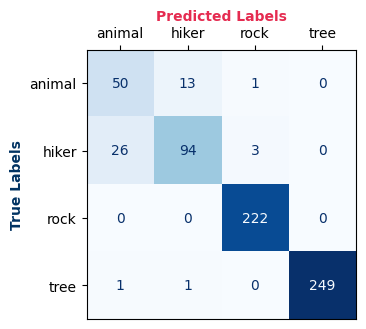

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# make a subplot:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# plot the matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        cmap='Blues',
                                        colorbar=False,
                                        ax = ax)

# modify appearance
ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')
ax.set_ylabel('True Labels', weight='black', color='#003262')

# move xaxis label & ticks to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

In [ ]:
# class counts in the test set for comparison
y_test.value_counts()

label
tree      251
rock      222
hiker     123
animal     64
Name: count, dtype: int64

# **Evaluation**

In [ ]:
# import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

### [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Accuracy score: ', round(acc, 2))

Accuracy score:  0.93


### [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
# sklearn classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      animal       0.65      0.78      0.71        64
       hiker       0.87      0.76      0.81       123
        rock       0.98      1.00      0.99       222
        tree       1.00      0.99      1.00       251

    accuracy                           0.93       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.94      0.93      0.93       660



### [`imblearn.metrics.classification_report_imbalanced()`](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.classification_report_imbalanced.html)

In [ ]:
# imblearn classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

     animal       0.65      0.78      0.95      0.71      0.86      0.73        64
      hiker       0.87      0.76      0.97      0.81      0.86      0.73       123
       rock       0.98      1.00      0.99      0.99      1.00      0.99       222
       tree       1.00      0.99      1.00      1.00      1.00      0.99       251

avg / total       0.94      0.93      0.99      0.93      0.96      0.92       660



# **Conclusion**
> In this notebook, I've implemented the following:

> + Resampled training datasets using multiple sampling methods. However, I chose `SMOTENC` since one of the features, `color` was categorical. Also, `SMOTENC` yielded the best results in the confusion matrix
> + Stratified sampling, even though not documented here

> Despite all that, there seems to be dismal improvement in the model's overall performance 💔
+ `F1` score for the `animal` class increased from `0.67` to `0.71`, whereas the `F1` score for the `hiker` class decreased from `0.83` to `0.81` (comaped to the previous notebook where the training set had not been resampled)

> 💡 **Insight**  
> + Clearly, __quality data selection__ wins over oversampling (especially if the minority classes are inherently lacking in size and diversity) since the model still performs poorly on the `animal` and `hiker` classes, even after resampling


> ▶️ **Up Next**  
+ Compute Receiver operating Characteristic Curve - `RocCurve`
+ Area Under Curve - `AUC`